In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.integrate import cumulative_trapezoid
from numba import njit, vectorize

%matplotlib widget

### Common parameters

In [2]:
T_final = 15 #8.5*mass**2 + 40*mass

r0 = 15

m = 5

xM = 50.0
dx0 = 0.1
n_div = 1
dxs = [dx0 / 2**i for i in range(n_div)]

### Godunov

In [3]:
@njit
def der(f, h):
    f_x = np.zeros_like(f)
    f_x[0:3]   = (-147*f[0:3]+360*f[1:4]-450*f[2:5]+400*f[3:6]-225*f[4:7]+72*f[5:8]-10*f[6:9])/(60*h)
    f_x[-3:] = (10*f[-9:-6]-72*f[-8:-5]+225*f[-7:-4]-400*f[-6:-3]+450*f[-5:-2]-360*f[-4:-1]+147*f[-3:])/(60*h)
    f_x[3:-3]  = (-f[0:-6]+9*f[1:-5]-45*f[2:-4]+45*f[4:-2]-9*f[5:-1]+f[6:])/(60*h)
    return f_x

@vectorize
def heaviside(x):
    if x < 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 0.5

@njit
def tloop(B, X, dx, XN, T_final):
    t=0

    done = False
    while done == False:
        
        # CFL condition
        dt = CLF(B, X, dx)
        # Advance time
        if t + dt > T_final:
            dt = T_final - t
            t = T_final
            done = True
        else:
            t = t + dt

        Bt = B.copy()

        B[0] = 0 # inner boundary condition, since B = x*b, at x=0 we have B=0
        # flux from B(1) into B(2) is 0
        B[1] = Bt[1] - dt/dx * flux(Bt[1] / X[1]**2, Bt[2] / X[2]**2, (X[1] + X[2]) / 2)
        for j in range(2, XN-1):
            B[j] = Bt[j] - dt/dx * ( flux(Bt[j] / X[j]**2, Bt[j+1] / X[j+1]**2, (X[j] + X[j+1]) / 2) - flux(Bt[j-1] / X[j-1]**2, Bt[j] / X  [j]**2, (X[j-1] + X[j])/2) )
        # outer boundary condition: no dynamics for B(XN) (see limits on the
        # for loop above) implies no incoming matter from beyond XN.

        Rho_dt = (Bt - B) / X**2 / (4*np.pi*dt) # from Eq. (4.15)
        Rho_dx = der(X**3 * np.sin(B / X**2)**2, dx) / (8 * np.pi * X**2)

    return B, Rho_dt, Rho_dx, t

@njit
def flux(ul, ur, x):
    FL = 0.5 * x**3 * np.sin(ul)**2 
    FR = 0.5 * x**3 * np.sin(ur)**2 
    ll = np.array([FL, FR])
    if ul <= ur:
        return np.min(ll)
    elif ul > ur:
        if ((ur > -np.pi/2) or (ul < -np.pi/2)):
            return np.max(ll)
        else:
            return 0.5 * x**3

@njit
def CLF(B, X, dx, fact = 0.45):
    # Set dt using velocity of characteristics
    vel = X * np.sin(B / X**2) * np.cos(B / X**2)
    v = np.max(np.array([-np.min(vel), np.max(vel)]))

    # CFL condition
    dt = fact * dx / np.abs(v)
    if dt > dx / 20:
       dt = dx / 20  # largest timestep allowed
    return dt

godunov = {}

for k, dx in enumerate(dxs):
    X = np.linspace(0, xM, int(1 + xM / dx), dtype=np.float64) + 1e-16
    XN = len(X)

    M = m * X**3 / r0**3 * heaviside(r0 - X) + m * heaviside(X - r0)
    B = - 0.5 * X**2 * np.arccos(1 - 4 * M / X**3)
    B[0] = B[1]

    B, Rho_dt, Rho_dx, t = tloop(B, X, dx, XN, T_final)
    
    godunov[k] = {}
    godunov[k]['dx'] = dx
    godunov[k]['x']  = X
    godunov[k]['B']  = B.copy()
    godunov[k]['rho_dt']  = Rho_dt.copy()
    godunov[k]['rho_dx']  = Rho_dx.copy()
    godunov[k]['t'] = t

### WENO

In [4]:
@njit
def f(u, x):
    return 0.5 * x*x*x * np.sin(u / x/x)**2 

@njit
def fp(u, x):
    return 0.5 * x * np.sin(2 * u /x/x)

def initial_data(x, m, r0, h):

    # rho = 3 * m * (1 - heaviside(xs-r0)) / (4 * np.pi * r0**3)
    # rho = 3 * m / (4*np.pi * r0**3) * (np.pi/2 - np.arctan(x - r0))/2
    
    # M = 4*np.pi * cumulative_trapezoid(rho * x*x, x, initial=0)
    # print(f'Mass computed at infinity = {np.round(M[-1],3)}')

    M = m * x**3 / r0**3 * heaviside(r0 - x) + m * heaviside(x - r0)

    B0 = - 0.5 * x**2 * np.arccos(1 - 4 * M / x**3)
    B0[0] = 0
    
    return B0

@vectorize
def heaviside(x):
    if x < 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 0.5

@njit
def TDV_RK(r, u_prev, xs, h, dt, nghost):
    if r == 2:
        return TDV_RK3(u_prev, xs, h, dt, nghost)
    else:
        raise Exception("Order not implemented! r = 2 or 3")

@njit
def L(r, j, u, fup, xs, h, nghost):
    """
    Equation 2.7b

    u  --> array of sol
    xs --> array of grid
    
    x_jm = x_{j - 1/2}
    x_jM = x_{j + 1/2}

    R(r, j  , x_jM, u, fup, xs, h) = f(x_{j + 1/2})
    """
    x_jM = xs[j] + h / 2
    x_jm = xs[j] - h / 2
    if j == nghost:
        o1 = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2 = 0
    else:
        o1 = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2 = flux( R(r, j-1, x_jm, u, fup, xs, h), R(r, j  , x_jm, u, fup, xs, h), x_jm)
    return - ( o1 - o2 ) / h, o1, o2

@njit
def R(r, j, x_pt, u, fup, xs, h):
    if r == 2:
        return R2(j, x_pt, u, fup, xs, h)

@njit
def alpha(r, j, i, u, fup, x, h):
    if r == 2:
        return alpha_r2(j, i, u, fup, x, h)

@njit
def interpolants(r, j, x, u, xs, h):
    if r == 2:
        return interp_r2(j, x, u, xs, h)

@njit
def SI(r, j, u):
    if r == 2:
        return SI_r2(j, u)

# @njit
# def flux(a, b, x):
#     """
#     Roe flux function
#     Equation 2.6
#     """
#     u_dec = np.linspace(min(a,b), max(a,b))
#     der = fp(u_dec, x)
#     if np.all(der >= 0):
#         return f(a, x)
#     elif np.all(der < 0):
#         return f(b, x)
#     else:
#         beta = np.max(np.abs(der)) 
#         return 0.5* (f(a, x) + f(b, x) - beta * (b - a))

# @njit
# def flux(a, b, x):
#     """
#     Godunov flux function
#     Equation 2.5
#     """
#     u_dec = np.linspace(np.min(a,b), np.max(a,b), 100)
#     if a <= b:
#         return np.min(f(u_dec, x))
#     elif a > b:
#         return np.max(f(u_dec, x))

@njit
def flux(a, b, x):
    ul = a/x/x
    ur = b/x/x
    FL = 0.5 * x**3 * np.sin(ul)**2 
    FR = 0.5 * x**3 * np.sin(ur)**2 
    ll = np.array([FL, FR])
    if ul <= ur:
        return np.min(ll)
    elif ul > ur:
        if ((ur > -np.pi/2) or (ul < -np.pi/2)):
            return np.max(ll)
        else:
            return 0.5 * x**3

@njit
def BC(arr, nghost):
    arr[:nghost] = arr[nghost]
    arr[-nghost:] = arr[-nghost - 1]
    return arr

@njit
def TDV_RK3(u_prev, xs, h, dt, nghost):
    """
    ## TO OPTIMIZE

    1**) Euler step t      --> t +   dt
    2**) Euler step t + dt --> t + 2*dt
    
    3**) Weighted mean btw t and t+2*dt to find t + dt/2
    
    4**) Euler step t + dt/2 -- > t + 3*dt/2
    
    5**) Weighted mean btw t and t+3*dt/2 to find  t + dt
    """
    rr = np.zeros(len(u_prev) - 2*nghost)
    FM = np.zeros_like(u_prev)
    Fm = np.zeros_like(u_prev)
    u_n1    = np.zeros_like(u_prev)
    u_n2    = np.zeros_like(u_prev)
    u_n12   = np.zeros_like(u_prev)
    u_n32   = np.zeros_like(u_prev)
    u_final = np.zeros_like(u_prev)

    fup = fp(u_prev, xs)
    # 1**)
    for j in range(len(rr)-1):
        rr[j], _, _ = L(2, j+nghost, u_prev, fup, xs, h, nghost)
    u_n1[nghost] = 0
    u_n1[nghost+1:-nghost] = u_prev[nghost+1:-nghost] + dt * rr[1:]
    u_n1 = BC(u_n1, nghost)
    fup = fp(u_n1, xs)

    # 2**)
    for j in range(len(rr)-1):
        rr[j], _, _ = L(2, j+nghost, u_n1, fup, xs, h, nghost)
    u_n2[nghost] = 0
    u_n2[nghost+1:-nghost] = u_n1[nghost+1:-nghost] + dt * rr[1:]
    u_n2 = BC(u_n2, nghost)

    # 3**)
    u_n12[nghost] = 0
    u_n12[nghost+1:-nghost] = 3 * u_prev[nghost+1:-nghost] / 4 + u_n2[nghost+1:-nghost] / 4
    u_n12 = BC(u_n12, nghost)
    fup = fp(u_n12, xs)

    # 4**)
    for j in range(len(rr)-1):
        rr[j], _, _ = L(2, j+nghost, u_n12, fup, xs, h, nghost)
    u_n32[nghost] = 0
    u_n32[nghost+1:-nghost] = u_n12[nghost+1:-nghost] + dt * rr[1:]
    u_n32 = BC(u_n32, nghost)

    # 5**)
    u_final[nghost] = 0
    u_final[nghost+1:-nghost] = u_prev[nghost+1:-nghost] / 3 + 2 * u_n32[nghost+1:-nghost] / 3
    u_final = BC(u_final, nghost)

    fup = fp(u_final, xs)
    for j in range(len(rr)-1):
        _, FM[j], Fm[j] = L(2, j+nghost, u_final, fup, xs, h, nghost)
    return u_final, FM, Fm

@njit
def R2(j, x_pt, u, fup, xs, h):
    """
    Equation 3.16
    """
    aj0 = alpha(2, j, 0, u, fup, x_pt, h)
    aj1 = alpha(2, j, 1, u, fup, x_pt, h)
    d = aj0 + aj1
    w0 = aj0 / d
    w1 = aj1 / d
    out = w0 * interpolants(2, j, x_pt, u, xs, h) + w1 * interpolants(2, j+1, x_pt, u, xs, h)
    return out

@njit
def alpha_r2(j, i, u, fup, x, h, eps = 1e-6):
    """
    Equations 3.17a & 3.17b 
    """
    if fup[j] > 0:
        if i == 0:
            return 1 / 2 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / (eps + SI(2, j+1, u))**2
    elif fup[j] <= 0:
        if i == 0:
            return 1 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / 2 / (eps + SI(2, j+1, u))**2

@njit
def interp_r2(j, x, u, xs, h):
    return u[j-1] + (u[j] - u[j-1]) * (x - xs[j-1]) / h

@njit
def SI_r2(j, u):
    return (u[j] - u[j-1])**2

@njit
def CLF(u, xs, dx, fact = 0.2):
    # Set dt using velocity of characteristics
    vel = xs * np.sin(u / xs/xs) * np.cos(u / xs/xs)
    v = np.max(np.array([-np.min(vel), np.max(vel)]))

    # CFL condition
    dt = fact * dx / np.abs(v)
    if dt > 0.01*dx:
       dt = 0.01*dx  # largest timestep allowed
    return dt

# @njit
# def CLF_np(u, xs, dx, fact = 0.45):
#     # Set dt using velocity of characteristics
#     vel = xs * np.sin(u / xs**2) * np.cos(u / xs**2)
#     v_abs = np.abs(vel).max()

#     # Compute dt
#     dt = fact * dx / v_abs
#     if dt > 0.02:  # largest timestep allowed
#         dt = 0.02
#     return dt

# dt_np = CLF_np(u_p[nghost:-nghost], x_phys, h)
# dt    = CLF(u_p[nghost:-nghost], x_phys, h)
# np.testing.assert_almost_equal(dt, dt_np)

@njit
def der(f, h):
    f_x = np.zeros_like(f)
    f_x[0:3]   = (-147*f[0:3]+360*f[1:4]-450*f[2:5]+400*f[3:6]-225*f[4:7]+72*f[5:8]-10*f[6:9])/(60*h)
    f_x[-3:] = (10*f[-9:-6]-72*f[-8:-5]+225*f[-7:-4]-400*f[-6:-3]+450*f[-5:-2]-360*f[-4:-1]+147*f[-3:])/(60*h)
    f_x[3:-3]  = (-f[0:-6]+9*f[1:-5]-45*f[2:-4]+45*f[4:-2]-9*f[5:-1]+f[6:])/(60*h)
    return f_x



import time

wenor2 = {}
wenor3 = {}
for r in [2]:

    if r == 2:
        nghost = 1
    elif r == 3:
        nghost = 2

    for k, h in enumerate(dxs):
        print('r = ', r)
        print('h = ', h)
        t1 = time.time()

        # Grid
        nx = int(xM / h + 1 + 2*nghost)
        xs = np.array([0.01*h + (i-nghost)*h for i in range(nx)])
        x_phys = xs[nghost:-nghost]

        # Initial Data
        u_p = np.zeros_like(xs)
        u_p[nghost:-nghost] = initial_data(x_phys, m, r0, h)
        u_p = BC(u_p, nghost)

        t = 0
        while t < T_final:
            # Compute dt
            dt = CLF(u_p[nghost:-nghost], x_phys, h)
            # Advance time
            if t + dt > T_final:
                dt = T_final - t
                t = T_final
            else:
                t = t + dt

            # RK timestep
            u, _, _ = TDV_RK(r, u_p, xs, h, dt, nghost)
           
            if t < T_final:
                u_p = u.copy()

        print(f'Done in {time.time() - t1} s')
        if r == 2:
            wenor2[k] = {}
            wenor2[k]['r'] = r
            wenor2[k]['dx'] = h
            wenor2[k]['x']  = x_phys
            wenor2[k]['t']  = t
            wenor2[k]['B']  = u[nghost:-nghost].copy()
            wenor2[k]['rho_dx'] = der(x_phys**3 * np.sin(u[nghost:-nghost] / x_phys**2)**2, h) / (8 * np.pi * x_phys**2)
            wenor2[k]['rho_dt'] = (u_p[nghost:-nghost] - u[nghost:-nghost]) / x_phys**2 / (4*np.pi*dt)
        elif r == 3:
            wenor3[k] = {}
            wenor3[k]['r'] = r
            wenor3[k]['dx'] = h
            wenor3[k]['x']  = x_phys
            wenor3[k]['t']  = t
            wenor3[k]['B']  = u[nghost:-nghost].copy()
            wenor3[k]['rho_dx'] = der(x_phys**3 * np.sin(u[nghost:-nghost] / x_phys**2)**2, h) / (8 * np.pi * x_phys**2)
            wenor3[k]['rho_dt'] = (u_p[nghost:-nghost] - u[nghost:-nghost]) / x_phys**2 / (4*np.pi*dt)

r =  2
h =  0.1
Done in 8.732779026031494 s


In [17]:
# import pickle
# with open('results/godunov.pickle', 'wb') as handle:
#     pickle.dump(godunov, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('results/wenor2.pickle', 'wb') as handle:
#     pickle.dump(wenor2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('results/wenor3.pickle', 'wb') as handle:
#     pickle.dump(wenor3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# import pickle
# with open('results/godunov.pickle', 'rb') as handle:
#     godunov = pickle.load(handle)
# with open('results/wenor2.pickle', 'rb') as handle:
#     wenor2 = pickle.load(handle)
# with open('results/wenor3.pickle', 'rb') as handle:
#     wenor3 = pickle.load(handle)

# with open('results/godunov_postBounce.pickle', 'rb') as handle:
#     godunov_pb = pickle.load(handle)
# with open('results/wenor2_postBounce.pickle', 'rb') as handle:
#     wenor2_pb = pickle.load(handle)
# with open('results/wenor3_postBounce.pickle', 'rb') as handle:
#     wenor3_pb = pickle.load(handle)

WENO - r = 2 :
t_max = 15
dx = 0.1
Total recomputed mass = 4.999852308777366

Godunov method - first order:
t_max = 15.0
dx = 0.1
Total recomputed mass = 5.000000268208728


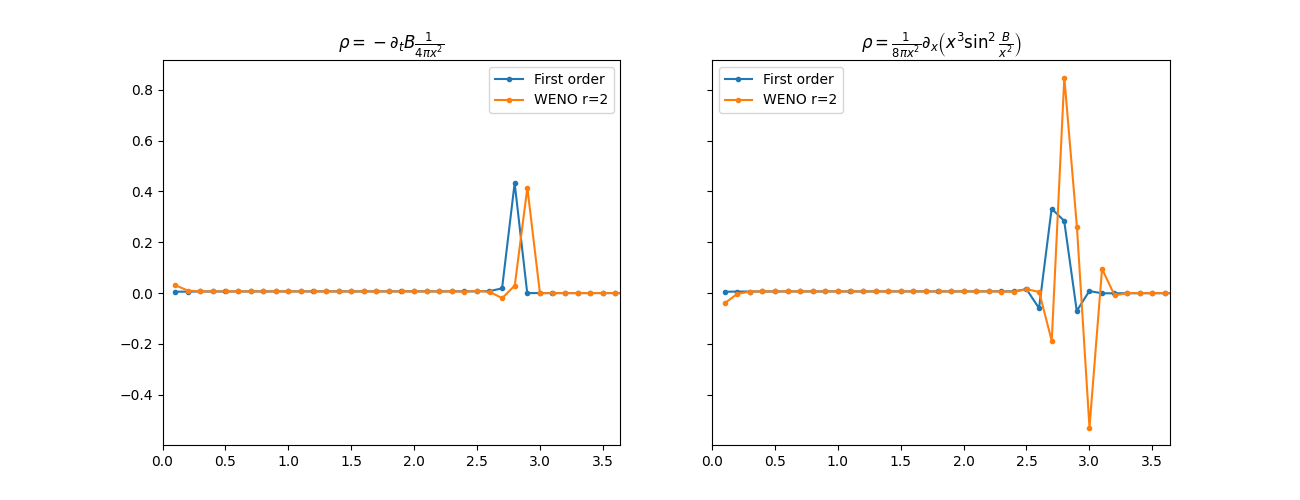

In [16]:
from scipy.integrate import simps

k = 0

fig, axs = plt.subplots(1,2,figsize=(13, 5), sharex = True, sharey = True)
axs[0].plot(godunov[k]['x'][1:],  godunov[k]['rho_dt'][1:], '.-', label = 'First order')
axs[0].plot(wenor2[k]['x'][1:], wenor2[k]['rho_dt'][1:], '.-', label = 'WENO r=2')
# axs[0].plot(wenor3[k]['x'][3:], wenor3[k]['rho_dt'][3:], '--', alpha = 0.5, label = 'WENO r=3')
axs[0].set_title(r"$\rho = -\partial_t B \frac{1}{4\pi x^2}$")
axs[0].legend()

axs[1].plot(godunov[k]['x'][1:], godunov[k]['rho_dx'][1:], '.-', label = 'First order')
axs[1].plot(wenor2[k]['x'][1:], wenor2[k]['rho_dx'][1:], '.-', label = 'WENO r=2')
# axs[1].plot(wenor3[k]['x'][3:], wenor3[k]['rho_dx'][3:], '--', alpha = 0.5, label = 'WENO r=3')
axs[1].set_title(r"$\rho = \frac{1}{8\pi x^2} \partial_x\left( x^3 \sin^2 \frac{B}{x^2} \right)$")
axs[1].legend()

plt.xlim((0, 1.3*wenor2[k]['x'][np.argmax(wenor2[k]['rho_dt'][1:])]))

print('WENO - r = 2 :')
print(f"t_max = {wenor2[k]['t']}")
print(f"dx = {wenor2[k]['dx']}")
print(f"Total recomputed mass = {4*np.pi*simps(wenor2[k]['rho_dx']*wenor2[k]['x']*wenor2[k]['x'], wenor2[k]['x'])}")
print()
# print('WENO - r = 3 :')
# print(f"t_max = {wenor3[k]['t']}")
# print(f"dx = {wenor3[k]['dx']}")
# print(f"Total recomputed mass = {4*np.pi*simps(wenor3[k]['rho_dx']*wenor3[k]['x']*wenor3[k]['x'], wenor3[k]['x'])}")
# print()§
print('Godunov method - first order:')
print(f"t_max = {godunov[k]['t']}")
print(f"dx = {godunov[k]['dx']}")
print(f"Total recomputed mass = {4*np.pi*simps(godunov[k]['rho_dx']*godunov[k]['x']*godunov[k]['x'], godunov[k]['x'])}")

NameError: name 'godunov_pb' is not defined

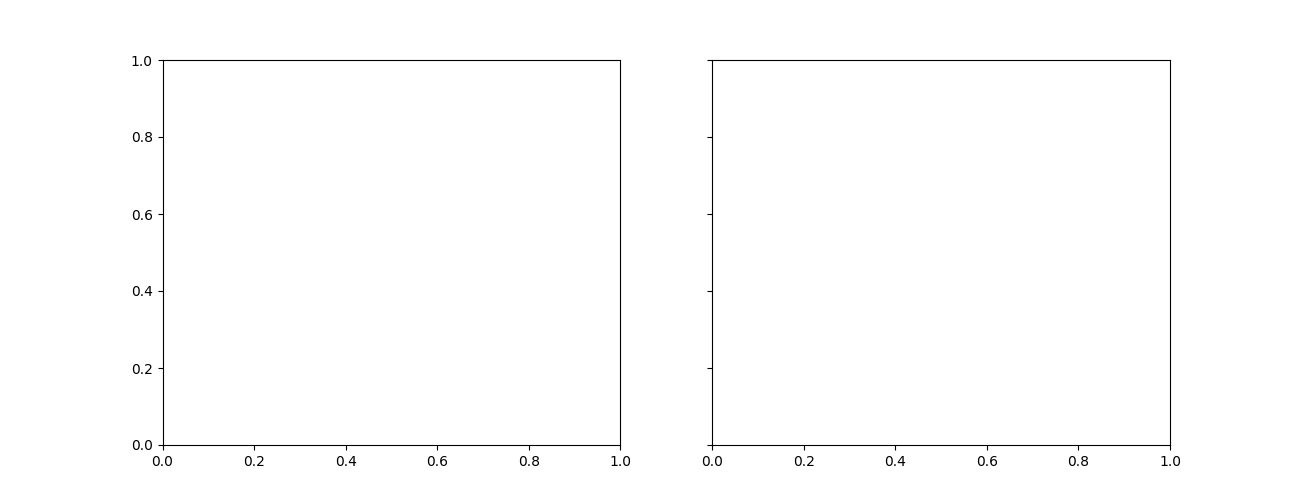

In [6]:
k = 0

fig, axs = plt.subplots(1,2,figsize=(13, 5), sharex = True, sharey = True)
axs[0].plot(godunov[k]['x'][3:], godunov_pb[k]['rho_dt'][3:], '.-', label = 'First order')
axs[0].plot(wenor2[k]['x'][3:], wenor2_pb[k]['rho_dt'][3:], '.-', label = 'WENO r=2')
axs[0].plot(wenor3[k]['x'][3:], wenor3_pb[k]['rho_dt'][3:], '.-', alpha = 0.5, label = 'WENO r=3')
axs[0].set_title(r"$\rho = -\partial_t B \frac{1}{4\pi x^2}$")
axs[0].legend()

axs[1].plot(godunov[k]['x'][3:], godunov_pb[k]['rho_dx'][3:], label = 'First order')
axs[1].plot(wenor2[k]['x'][3:], wenor2_pb[k]['rho_dx'][3:], label = 'WENO r=2')
axs[1].plot(wenor3[k]['x'][3:], wenor3_pb[k]['rho_dx'][3:], '--', alpha = 0.5, label = 'WENO r=3')
axs[1].set_title(r"$\rho = \frac{1}{8\pi x^2} \partial_x\left( x^3 \sin^2 \frac{B}{x^2} \right)$")
axs[1].legend()

print('WENO - r = 2 :')
print(f"t_max = {wenor2[k]['t']}")
print(f"dx = {wenor2[k]['dx']}")
print(f"Total recomputed mass = {4*np.pi*simps(wenor2_pb[k]['rho_dx']*wenor2_pb[k]['x']*wenor2_pb[k]['x'], wenor2_pb[k]['x'])}")
print()
print('WENO - r = 3 :')
print(f"t_max = {wenor3[k]['t']}")
print(f"dx = {wenor3[k]['dx']}")
print(f"Total recomputed mass = {4*np.pi*simps(wenor3_pb[k]['rho_dx']*wenor3_pb[k]['x']*wenor3_pb[k]['x'], wenor3_pb[k]['x'])}")
print()
print('Godunov method - first order:')
print(f"t_max = {godunov[k]['t']}")
print(f"dx = {godunov[k]['dx']}")
print(f"Total recomputed mass = {4*np.pi*simps(godunov_pb[k]['rho_dx']*godunov_pb[k]['x']*godunov_pb[k]['x'], godunov[k]['x'])}")

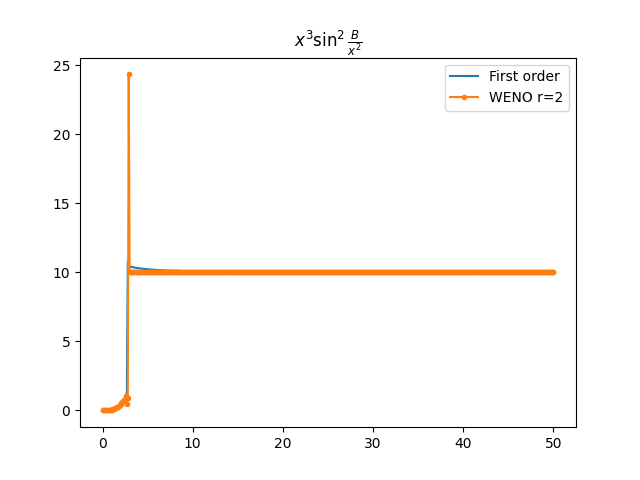

In [9]:
k = 0

fig = plt.figure()
plt.plot(godunov[k]['x'], godunov[k]['x']**3 * np.sin(godunov[k]['B']/godunov[k]['x']**2)**2, label = 'First order')
plt.plot(wenor2[k]['x'], wenor2[k]['x']**3 * np.sin(wenor2[k]['B']/wenor2[k]['x']**2)**2, '.-', label = 'WENO r=2')
# plt.plot(wenor3[k]['x'], wenor3[k]['x']**3 * np.sin(wenor3[k]['B']/wenor3[k]['x']**2)**2, '--', alpha = 0.5, label = 'WENO r=3')
plt.title(r"$ x^3 \sin^2 \frac{B}{x^2}$")
plt.legend()

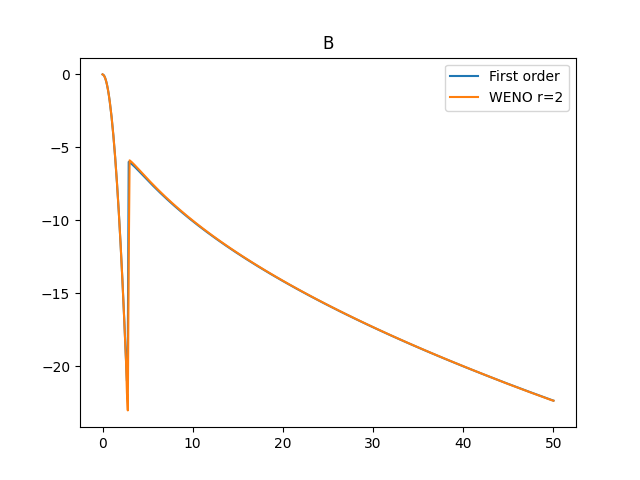

In [8]:
k = 0

fig = plt.figure()
plt.plot(godunov[k]['x'], godunov[k]['B'], label = 'First order')
plt.plot(wenor2[k]['x'], wenor2[k]['B'], label = 'WENO r=2')
# plt.plot(wenor3[k]['x'], wenor3[k]['B'], '--', alpha = 0.5, label = 'WENO r=3')
plt.title(r"B")
plt.legend()